In [40]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

## Dummy Submission (All-Positive)

In [41]:
def dummy_submit():
    submission_df = pd.read_csv('../input/spaceship-titanic/sample_submission.csv')
    submission_df['Transported'] = True
    submission_df.to_csv('submission.csv', index=False)
    
# This is dummy, not real submit, comment out when you don't want dummy
# dummy_submit()

# Pre-processing

In [42]:
train_df = pd.read_csv('../input/spaceship-titanic/train.csv')
test_df = pd.read_csv('../input/spaceship-titanic/test.csv') # Does NOT contain y -> 'Transported'

# Replaces whitespace with NaN
train_df.replace(r'^\s+$', np.nan, regex=True) 
test_df.replace(r'^\s+$', np.nan, regex=True)

def splitData(dataframe):
    # Split "PassengerId" into "GroupId" & "IndividualId"
    dataframe["GroupId"] = dataframe["PassengerId"].str.split("_").str[0]
    dataframe["IndividualId"] = dataframe["PassengerId"].str.split("_").str[1]

    # Split "Cabin" into "Deck", "Number", & "Side"
    dataframe["Deck"] = dataframe["Cabin"].str.split("/").str[0]
    dataframe["Number"] = dataframe["Cabin"].str.split("/").str[1]
    dataframe["Side"] = dataframe["Cabin"].str.split("/").str[2]

    dataframe.shape
    dataframe.sort_index()

    return dataframe

train_df = splitData(train_df)
test_df = splitData(test_df)

In [43]:
train_df.replace(r'', np.nan)

numeric_features = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "GroupId", "Number"] 
categorical_features = ["HomePlanet", "Destination", "Deck", "CryoSleep", "VIP", "Side"] 
drop_features = ["Name", "PassengerId", "IndividualId", "Cabin"]  # do not include these features in modeling
passthrough_features = [] # do not apply any transformation

target = "Transported"

X_train = train_df.drop(columns=[target, *drop_features])
y_train = train_df[target]

X_test = test_df.drop(columns=[*drop_features]) # test_df does NOT contain target

<Axes: >

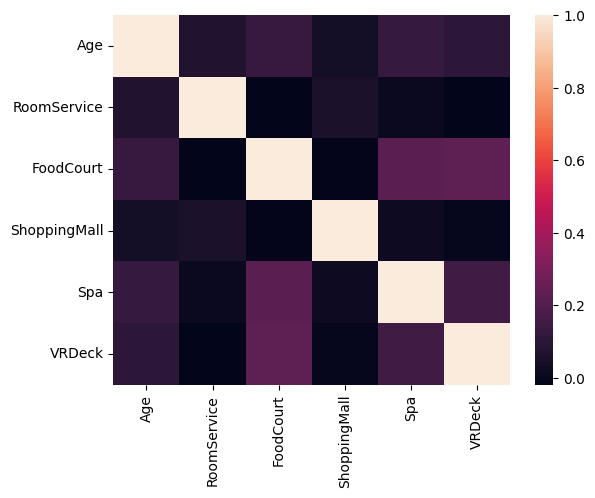

In [44]:
# finding corrolations 
# corr = X_train.corr(method='pearson', numeric_only=True)
# import seaborn as sns
# sns.heatmap(corr)

In [45]:
def fillCyro(df):
    # If people are spending, they are not asleep
    isNotAsleep = df[(df["CryoSleep"].isnull() == True) & (
            (df["Spa"] > 0) | 
            (df["RoomService"] > 0) | 
            (df["FoodCourt"] > 0) | 
            (df["VRDeck"] > 0) | 
            (df["ShoppingMall"] > 0)) 
        ].index
    df["CryoSleep"][isNotAsleep] = False
    
    # If people are aspleep, they are spending 0 money
    stores = ["Spa", "RoomService", "FoodCourt", "VRDeck", "ShoppingMall"]
    filledNull = 0
    for store in stores:
        isAsleep = df[(df["CryoSleep"] == True) & (df[store].isnull() == True) ].index
        filledNull += isAsleep.shape[0]
        df[store][isAsleep] = 0
    print(f"There are {df["CryoSleep"].isnull().sum()} null values left in sleep")
    print(f"Filled {filledNull} null spendings")

### Create Column Transformer

In [46]:
preprocessor = make_column_transformer(
    (make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy="mean"),
        StandardScaler() 
        ), numeric_features 
    ),
    (make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy="most_frequent"), 
        OneHotEncoder(sparse_output=False, handle_unknown="ignore")
        ), categorical_features
    ),
    remainder='drop'  # Keep non-transformed columns
)

In [47]:


# from class code
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [49]:
knn = False
fillCyro(X_train)
print(X_train)
if knn :
    testpipeline = make_pipeline(preprocessor, KNeighborsClassifier())
else:
    testpipeline = make_pipeline(preprocessor, SVC())

cv_scores = mean_std_cross_val_scores(testpipeline, X_train=X_train, y_train=y_train, cv=10, return_train_score=True)
print(cv_scores)

testpipeline.fit(X_train, y_train)
y_test = testpipeline.predict(X_test)

submission_df = pd.read_csv('../input/spaceship-titanic/sample_submission.csv')
submission_df['Transported'] = y_test
submission_df.to_csv('submission.csv', index=False)

C:\Users\3tfer\AppData\Local\Temp\ipykernel_8268\1635341127.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["CryoSleep"][isNotAsleep] = False
C:\Users\3tfer\AppData\Local\Temp\ipykernel_8268\1635341127.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[store][isAsleep] = 0
C:\Users\3tfer\AppData\Local\Temp\ipykernel_8268\1635341127.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[store][isAsleep] = 0
C:\Users\3tfer\

There are 98 null values left in sleep
Filled 0 null spendings
     HomePlanet CryoSleep    Destination   Age    VIP  RoomService  FoodCourt  \
0        Europa     False    TRAPPIST-1e  39.0  False          0.0        0.0   
1         Earth     False    TRAPPIST-1e  24.0  False        109.0        9.0   
2        Europa     False    TRAPPIST-1e  58.0   True         43.0     3576.0   
3        Europa     False    TRAPPIST-1e  33.0  False          0.0     1283.0   
4         Earth     False    TRAPPIST-1e  16.0  False        303.0       70.0   
...         ...       ...            ...   ...    ...          ...        ...   
8688     Europa     False    55 Cancri e  41.0   True          0.0     6819.0   
8689      Earth      True  PSO J318.5-22  18.0  False          0.0        0.0   
8690      Earth     False    TRAPPIST-1e  26.0  False          0.0        0.0   
8691     Europa     False    55 Cancri e  32.0  False          0.0     1049.0   
8692     Europa     False    TRAPPIST-1e  44.0

C:\Users\3tfer\AppData\Local\Temp\ipykernel_8268\551108912.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


fit_time       1.479 (+/- 0.056)
score_time     0.268 (+/- 0.014)
test_score     0.802 (+/- 0.020)
train_score    0.819 (+/- 0.002)
dtype: object
